**Part A: Data Preprocessing**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import set_config
set_config(display='diagram')

In [2]:
# Load data
df = pd.read_csv("data/bank-additional-full.csv", sep=';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


**A.a Handle Missing Values**

In [4]:
# Handle 'unknown' in categorical features
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 
                'contact', 'month', 'day_of_week', 'poutcome']
for col in cat_features:
    df[col] = df[col].replace('unknown', np.nan)
    df[col] = df[col].fillna(df[col].mode()[0])

In [5]:
# Remove duration column as per assignment instructions
df = df.drop('duration', axis=1)

**A.b Feature Encoding**

In [6]:
# Split data before preprocessing
X = df.drop('y', axis=1)
y = df['y'].map({'no':0, 'yes':1})
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Define preprocessing pipeline
numeric_features = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 
                   'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan',
                'contact', 'month', 'day_of_week', 'poutcome']

In [8]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

In [9]:
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

In [10]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, cat_features)])

**A.c Feature Scaling Visualization**

Text(0.5, 1.0, 'Age Before Scaling')

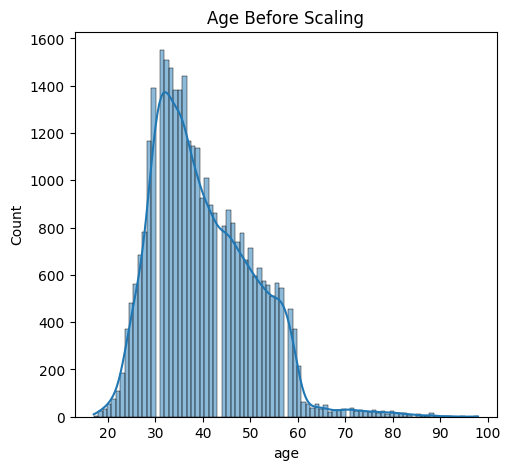

In [11]:
# Visualize age distribution before/after scaling
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(X_train['age'], kde=True)
plt.title('Age Before Scaling')

In [12]:
temp_pipe = Pipeline(steps=[('scaler', StandardScaler())])
scaled_age = temp_pipe.fit_transform(X_train[['age']])

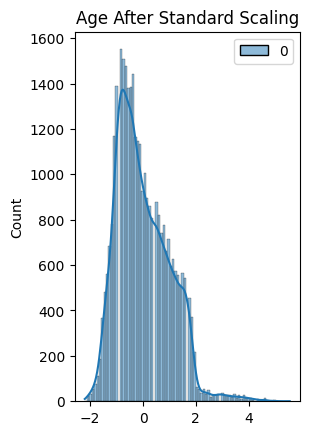

In [13]:
plt.subplot(1,2,2)
sns.histplot(scaled_age, kde=True)
plt.title('Age After Standard Scaling')
plt.show()

**Part B: Model Training**

**Model 1: Support Vector Machine (SVM)**

In [18]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import joblib

In [16]:
# SVM Pipeline
svm_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', SVC(kernel='rbf', 
                      class_weight='balanced', 
                      probability=True,
                      random_state=42))
])

In [17]:
# Train SVM
svm_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier',
                 SVC(class_weight='balanced', probability=True,
                     random_state=42))])

In [19]:
# Evaluate SVM
y_pred_svm = svm_pipe.predict(X_test)
svm_accuracy = accuracy_score(y_test, y_pred_svm)
svm_report = classification_report(y_test, y_pred_svm)

In [20]:
print("=== SVM Model ===")
print(f"Accuracy: {svm_accuracy:.2f}")
print("Classification Report:")
print(svm_report)

=== SVM Model ===
Accuracy: 0.85
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.89      0.91      7303
           1       0.40      0.59      0.47       935

    accuracy                           0.85      8238
   macro avg       0.67      0.74      0.69      8238
weighted avg       0.88      0.85      0.86      8238



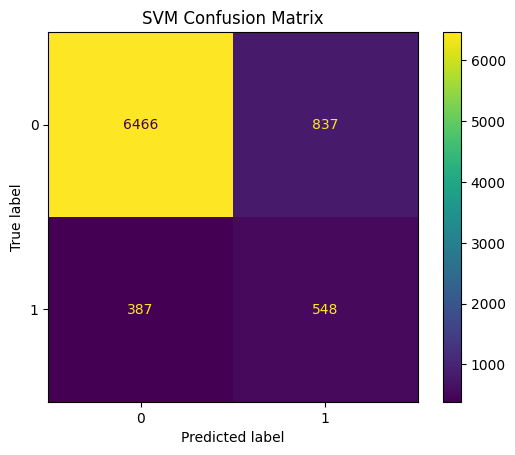

In [21]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(svm_pipe, X_test, y_test)
plt.title("SVM Confusion Matrix")
plt.show()

In [22]:
# Save SVM model
joblib.dump(svm_pipe, 'svm_model.pkl')

['svm_model.pkl']

**Model 2: Logistic Regression**

In [23]:
# Logistic Regression Pipeline
logreg_pipe = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000,
                                     class_weight='balanced',
                                     random_state=42))
])

In [24]:
# Train Logistic Regression
logreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'campaign', 'pdays',
                                                   'previous', 'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx', 'euribor3m',
                                                   'nr.employed']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['job', 'marital',
                                                   'education', 'default',
                                                   'housing', 'loan', 'contact',
                                                   'month', 'day_of_week',
                                                   'poutcome'])])),
                ('classifier',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    random_state=42))])

In [25]:
# Evaluate Logistic Regression
y_pred_logreg = logreg_pipe.predict(X_test)
logreg_accuracy = accuracy_score(y_test, y_pred_logreg)
logreg_report = classification_report(y_test, y_pred_logreg)

In [26]:
print("\n=== Logistic Regression Model ===")
print(f"Accuracy: {logreg_accuracy:.2f}")
print("Classification Report:")
print(logreg_report)


=== Logistic Regression Model ===
Accuracy: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.86      0.90      7303
           1       0.35      0.61      0.44       935

    accuracy                           0.83      8238
   macro avg       0.65      0.73      0.67      8238
weighted avg       0.88      0.83      0.85      8238



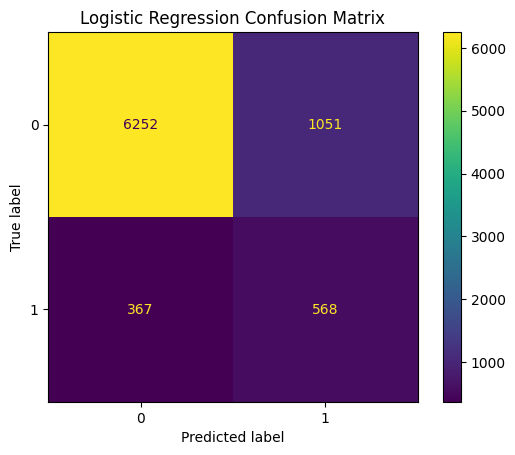

In [27]:
# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(logreg_pipe, X_test, y_test)
plt.title("Logistic Regression Confusion Matrix")
plt.show()

In [28]:
# Save Logistic Regression model
joblib.dump(logreg_pipe, 'logreg_model.pkl')

['logreg_model.pkl']

**Model Comparison**

In [29]:
print("\nModel Performance Summary:")
print(f"SVM Accuracy: {svm_accuracy:.2%}")
print(f"Logistic Regression Accuracy: {logreg_accuracy:.2%}")


Model Performance Summary:
SVM Accuracy: 85.14%
Logistic Regression Accuracy: 82.79%


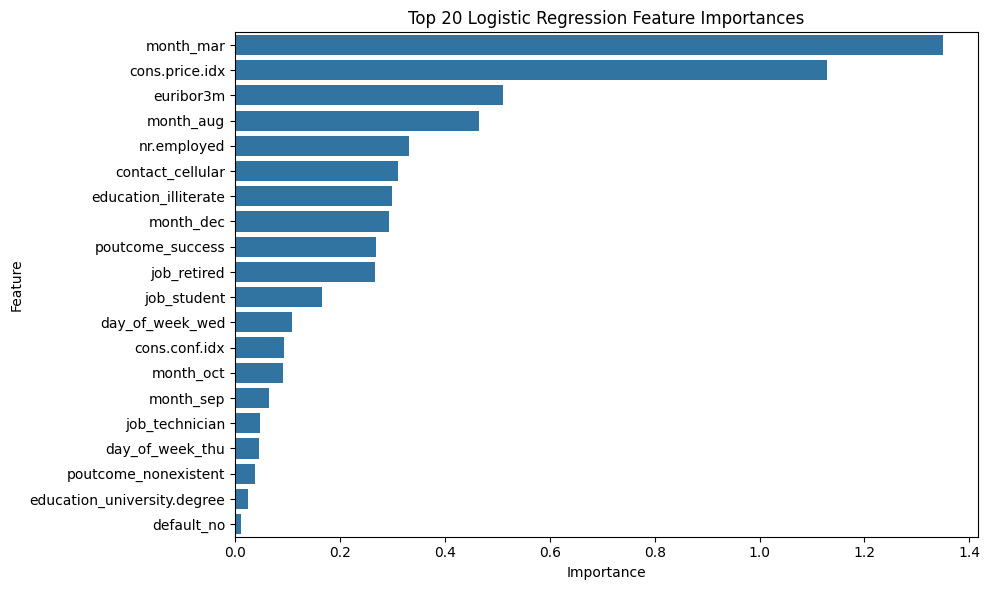

In [30]:
# Feature Importance (for Logistic Regression)
if hasattr(logreg_pipe.named_steps['classifier'], 'coef_'):
    feature_names = (logreg_pipe.named_steps['preprocessor']
                     .transformers_[1][1]
                     .named_steps['onehot']
                     .get_feature_names_out(cat_features))
    
    all_feature_names = numeric_features + list(feature_names)
    coefficients = logreg_pipe.named_steps['classifier'].coef_[0]
    
    feat_importance = pd.DataFrame({
        'Feature': all_feature_names,
        'Importance': coefficients
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10,6))
    sns.barplot(x='Importance', y='Feature', 
                data=feat_importance.head(20))
    plt.title("Top 20 Logistic Regression Feature Importances")
    plt.tight_layout()
    plt.show()